In [2]:
import os
import config
from tqdm import tqdm
DATA_PATH = config.DATA_PATH
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [ ]:
"""
working directory initialization
os.command("rm -rf /home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld")
os.mkdir("/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld")
os.chdir("/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld")
os.mkdir("0pixel_margin")
os.mkdir("0pixel_margin/entire")
os.mkdir("0pixel_margin/part")
os.mkdir("0pixel_margin/entire/ACC")
os.mkdir("0pixel_margin/entire/REJ")
os.mkdir("0pixel_margin/part/ACC")
os.mkdir("0pixel_margin/part/REJ")
os.mkdir("30pixel_margin")
os.mkdir("30pixel_margin/entire")
os.mkdir("30pixel_margin/part")
os.mkdir("30pixel_margin/entire/ACC")
os.mkdir("30pixel_margin/entire/REJ")
os.mkdir("30pixel_margin/part/ACC")
os.mkdir("30pixel_margin/part/REJ")
os.mkdir("60pixel_margin")
os.mkdir("60pixel_margin/entire")
os.mkdir("60pixel_margin/part")
os.mkdir("60pixel_margin/entire/ACC")
os.mkdir("60pixel_margin/entire/REJ")
os.mkdir("60pixel_margin/part/ACC")
os.mkdir("60pixel_margin/part/REJ")
"""


1. tif to jpg


In [ ]:
image_list = os.listdir(DATA_PATH+"/Raw/ACC")
#convert .tif to .jpg
for i in tqdm(range(len(image_list))):
    img = cv2.imread(DATA_PATH+"/Raw/ACC/"+image_list[i])
    cv2.imwrite(DATA_PATH+"/Raw_jpg/ACC/"+image_list[i].split(".")[0]+".jpg", img)
    
image_list = os.listdir(DATA_PATH+"/Raw/REJ")
#convert .tif to .jpg
for i in tqdm(range(len(image_list))):
    img = cv2.imread(DATA_PATH+"/Raw/REJ/"+image_list[i])
    cv2.imwrite(DATA_PATH+"/Raw_jpg/REJ/"+image_list[i].split(".")[0]+".jpg", img)


In [5]:
image_list = glob("/home/VirtualFlaw/Data/Raw/New" + '/**', recursive=True)
print(len(image_list))
for i in tqdm(range(len(image_list))):
    # if i is not image file, skip
    if not os.path.isfile(image_list[i]):
        continue
    img = cv2.imread(image_list[i])
    cv2.imwrite(DATA_PATH+"/Raw_jpg/New/"+image_list[i].split("/")[-1].split(".")[0]+".jpg", img)

26005


100%|██████████| 26005/26005 [20:08<00:00, 21.52it/s] 


2. part image nomalization

In [ ]:
DATA_PATH = config.RAW_DATA_PATH
ACC_image_list = glob(DATA_PATH+"/ACC/*.jpg")
REJ_image_list = glob(DATA_PATH+"/REJ/*.jpg")

for i in tqdm(range(len(ACC_image_list))):
    image = cv2.imread(ACC_image_list[i])
    origin_image = image.copy()
    data = image.reshape((-1, 3)).astype(np.float32)
    
    #kmeans
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 10, .0)
    k = 2
    ret, label, center = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    image = res.reshape((image.shape))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #sobel
    sobelx = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.uint8(sobelx)
    sobel = cv2.cvtColor(sobel, cv2.COLOR_BGR2GRAY)
    # 허프 변환 적용 
    try:
        
        lines = cv2.HoughLines(sobel, 1, np.pi/180, 615)
        x1, y1, x2, y2 = [], [], [], []
        for j in lines:
            rho, theta = j[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1.append(int(x0 + 1500 * (-b)))
            y1.append(int(y0 + 1500 * (a)))
            x2.append(int(x0 - 1500 * (-b)))
            y2.append(int(y0 - 1500 * (a)))
            
        x1_max, x2_max = int(max(x1)), int(max(x2))
        y1_max, y2_max = int(max(y1)), int(max(y2))
        x1_min, x2_min = int(min(x1)), int(min(x2))
        y1_min, y2_min = int(min(y1)), int(min(y2)) 
        
        y1 = int((y1_max + y2_max) / 2)
        y2 = int((y1_min + y2_min) / 2)
        
        if abs(y1 - y2) < 400 and abs(y1 - y2) > 150:

            calc_image = origin_image[y2:y1, 0:origin_image.shape[1]]
            #min-max normalization
            min_val = np.min(calc_image)
            max_val = np.max(calc_image)
            calc_image = (origin_image - min_val) / (max_val - min_val) * 255
            calc_image = np.array(calc_image, dtype=np.uint8)
            
            calc_image = cv2.cvtColor(calc_image, cv2.COLOR_BGR2RGB)
            
            cv2.imwrite("/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/entire/ACC/"+ACC_image_list[i].split("/")[-1], calc_image)
            calc_image = calc_image[y2:y1, 0:calc_image.shape[1]]
            
            cv2.imwrite("/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/part/ACC/"+ACC_image_list[i].split("/")[-1], calc_image)
            
    except Exception as e:
        continue
    

In [ ]:
DATA_PATH = config.RAW_DATA_PATH
ACC_image_list = glob(DATA_PATH+"/ACC/*.jpg")
REJ_image_list = glob(DATA_PATH+"/REJ/*.jpg")
pixel = 0
type_list = ["ACC", "REJ"]
for type in type_list:
    if type == "ACC":
        image_list = ACC_image_list
    else:
        image_list = REJ_image_list
        
    for i in tqdm(range(len(image_list))):
        image = cv2.imread(image_list[i])
        origin_image = image.copy()
        data = image.reshape((-1, 3)).astype(np.float32)
        
        #kmeans
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 10, .0)
        k = 2
        ret, label, center = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        image = res.reshape((image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #sobel
        sobelx = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
        sobel = np.uint8(sobelx)
        sobel = cv2.cvtColor(sobel, cv2.COLOR_BGR2GRAY)
        # 허프 변환 적용 
        try:
            
            lines = cv2.HoughLines(sobel, 1, np.pi/180, 615)
            x1, y1, x2, y2 = [], [], [], []
            for j in lines:
                rho, theta = j[0]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1.append(int(x0 + 1500 * (-b)))
                y1.append(int(y0 + 1500 * (a)))
                x2.append(int(x0 - 1500 * (-b)))
                y2.append(int(y0 - 1500 * (a)))
                
            x1_max, x2_max = int(max(x1)), int(max(x2))
            y1_max, y2_max = int(max(y1)), int(max(y2))
            x1_min, x2_min = int(min(x1)), int(min(x2))
            y1_min, y2_min = int(min(y1)), int(min(y2)) 
            y1 = int((y1_max + y2_max) / 2) + pixel
            y2 = int((y1_min + y2_min) / 2) - pixel

            if abs(y1 - y2) < 450 and abs(y1 - y2) > 150:
                pixel_list = [0, 30, 60]
                for pixel in pixel_list:
                    y1 = int((y1_max + y2_max) / 2) + pixel
                    y2 = int((y1_min + y2_min) / 2) - pixel
                    calc_image = origin_image[y2:y1, 0:origin_image.shape[1]]
                    #min-max normalization
                    min_val = np.min(calc_image)
                    max_val = np.max(calc_image)
                    calc_image = (origin_image - min_val) / (max_val - min_val) * 255
                    calc_image = np.array(calc_image, dtype=np.uint8)
                    
                    calc_image = cv2.cvtColor(calc_image, cv2.COLOR_BGR2RGB)
                    
                    cv2.imwrite(f"/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/{str(pixel)}pixel_margin/entire/{type}/"+image_list[i].split("/")[-1], calc_image)
                    
                    calc_image = calc_image[y2:y1, 0:calc_image.shape[1]]
                    
                    cv2.imwrite(f"/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/{str(pixel)}pixel_margin/part/{type}/"+image_list[i].split("/")[-1], calc_image)
                
        except Exception as e:
            continue
    

In [ ]:
def concat_img(img1_path, img2_path, img3_path, mode):
    """img1, img2, img3의 경로를 입력받아 세 이미지를 가로로 붙여서 저장 또는 시각화. 원본이 존재하는 경우 원본도 포함하여 equalizeHist, normalize를 적용함.

    Args:
        img1 (String): img1 경로
        img2 (String): img2 경로
        img3 (String): img3 경로
    """
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    img3 = cv2.imread(img3_path)
    try:
        img4 = cv2.imread("/home/VirtualFlaw/Data/Raw_jpg/ACC/"+img1_path.split("/")[-1])
        img4 = cv2.normalize(img4, None, 0, 255, cv2.NORM_MINMAX)
        merged = np.hstack((img4, img1, img2, img3))
        #convert to grayscale
        merged = cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY)
        #equalize histogram
        merged = cv2.equalizeHist(merged)
        merged = cv2.normalize(merged, None, 0, 255, cv2.NORM_MINMAX)
        #convert to color
        merged = cv2.cvtColor(merged, cv2.COLOR_GRAY2BGR)
        if mode == "save":
            cv2.imwrite("/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/result/"+img1_path.split("/")[-1], merged)
        elif mode == "show":
            plt.imshow(merged)
    except Exception as e:
        print(e)
        merged = np.hstack((img1, img2, img3))
        if mode == "save":
            cv2.imwrite("/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/result/"+img1_path.split("/")[-1], merged)
        elif mode == "show":
            plt.imshow(merged)
        
        
    
    

In [ ]:
pixel_0_PATH = "/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/0pixel_margin/entire/"
pixel_30_PATH = "/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/30pixel_margin/entire/"
pixel_60_PATH = "/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/60pixel_margin/entire/"
#위의 세 경로에서 아무 파일이나 골라서 아래에 전체 경로를 입력하면 해당 이미지를 시각화할 수 있음.
file_name = "/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/60pixel_margin/entire/ACC/22C023-14-002-1st-1-(1)-17.jpg"
category_file_name = file_name.split("/")[-2] + "/" + file_name.split("/")[-1]
print(category_file_name)
plt.figure(figsize=(20, 10))
concat_img(pixel_0_PATH+category_file_name, pixel_30_PATH+category_file_name, pixel_60_PATH+category_file_name, "show")

In [20]:
RAW_PATH = "/home/VirtualFlaw/Data/Raw_jpg/"
ACC_image_list = glob(RAW_PATH+"ACC/*.jpg")
REJ_image_list = glob(RAW_PATH+"REJ/*.jpg")

image_list = ACC_image_list + REJ_image_list
for i in tqdm(image_list):
    img = cv2.imread(i)
    margin_list = [0, 30, 60]
    for margin in margin_list:
        img_part = img[(img.shape[0]//3)-margin:(img.shape[0]//3*2)+margin, 0:img.shape[1]]
        """min_val = np.min(img_part)
        max_val = np.max(img_part)
        img = (img - min_val) / (max_val - min_val) * 255
        img = np.array(img, dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_part = img[(img.shape[0]//3)-margin:(img.shape[0]//3*2)+margin, 0:img.shape[1]]"""
        img_part = cv2.normalize(img_part, None, 0, 255, cv2.NORM_MINMAX)
        if "ACC" in i:
            type = "ACC"
            cv2.imwrite(f"/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_3part/{str(margin)}pixel_margin/{type}/{i.split('/')[-1]}", img_part)
        elif "REJ" in i:
            type = "REJ"
            cv2.imwrite(f"/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_3part/{str(margin)}pixel_margin/{type}/{i.split('/')[-1]}", img_part)

100%|██████████| 2957/2957 [02:08<00:00, 22.97it/s]


In [15]:
def concat_img(img1_path, img2_path, img3_path, mode):
    """img1, img2, img3의 경로를 입력받아 세 이미지를 가로로 붙여서 저장 또는 시각화. 원본이 존재하는 경우 원본도 포함하여 equalizeHist, normalize를 적용함.

    Args:
        img1 (String): img1 경로
        img2 (String): img2 경로
        img3 (String): img3 경로
    """
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    img3 = cv2.imread(img3_path)
    merged = np.vstack((img1, img2, img3))
    if mode == "save":
        cv2.imwrite("/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_weld/result/"+img1_path.split("/")[-1], merged)
    elif mode == "show":
        plt.imshow(merged)
        
        
    
    

ACC/22C045-47-038-1st-1-(2)-1.jpg


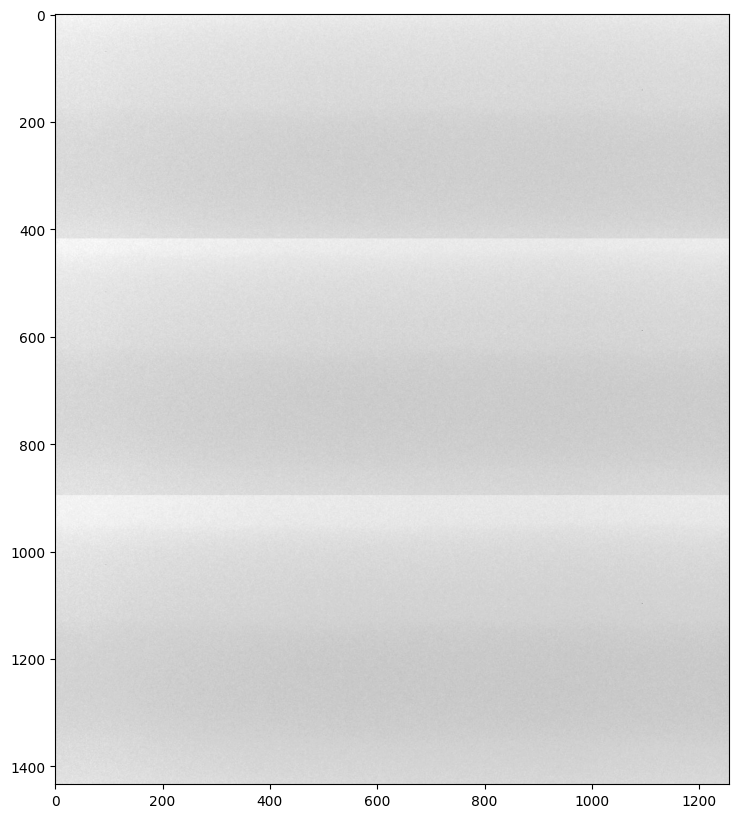

In [21]:
pixel_0_PATH = "/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_3part/0pixel_margin/"
pixel_30_PATH = "/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_3part/30pixel_margin/"
pixel_60_PATH = "/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_3part/60pixel_margin/"
#위의 세 경로에서 아무 파일이나 골라서 아래에 전체 경로를 입력하면 해당 이미지를 시각화할 수 있음.
file_name = "/home/VirtualFlaw/Hyun/Data/Preprocess/Nomalization_with_3part/60pixel_margin/ACC/22C045-47-038-1st-1-(2)-1.jpg"
category_file_name = file_name.split("/")[-2] + "/" + file_name.split("/")[-1]
print(category_file_name)
plt.figure(figsize=(20, 10))
concat_img(pixel_0_PATH+category_file_name, pixel_30_PATH+category_file_name, pixel_60_PATH+category_file_name, "show")